# SVB evaluation

In [1]:
%load_ext autoreload 
%autoreload 2 

import sys 
import numpy as np
import toblerone as tob 
import regtricks as rt 
import trimesh 

import matplotlib.pyplot as plt 
from matplotlib.cm import get_cmap
cmap = np.array(get_cmap('tab10').colors)
import seaborn as sns 
import pyvista as pv 
import fabber_funcs

sys.path.insert(1, '/Users/thomaskirk/Modules/svb_module')
from svb.main import run
from svb.data import HybridModel

import os.path as op
sys.path.append(op.join('.', '../svb_models_asl'))
from svb_models_asl import AslRestModel 

try:
    import tensorflow.compat.v1 as tf
    tf.disable_v2_behavior()
except ImportError:
    import tensorflow as tf

Instructions for updating:
non-resource variables are not supported in the long term


In [2]:
spc = rt.ImageSpace.create_axis_aligned(np.zeros(3), [10,10,10], [2,2,2])
pvgm = np.random.uniform(0.3, 0.7, size=spc.size)
pvwm = 1 - pvgm 

PLDS = [1.0, 1.25, 1.5, 1.75, 2]
nvox = spc.size.prod()

model_opts = { 
    "pvcorr": True, 
    "pvgm": pvgm, 
    "pvwm": pvwm, 
    "plds": PLDS, 
    "casl": True, 
}

In [3]:
def simulate_data(noise, rpt):
    
    data = np.zeros((*spc.size, len(PLDS) * rpt))
    data_model = VolumetricModel(spc.make_nifti(data))
    asl_model = AslRestModel(data_model, repeats=rpt, **model_opts)

    with tf.Session() as sess:
        gm_cbf = 60 * np.ones([nvox, 1], dtype=np.float32)
        wm_cbf = 20 * np.ones([nvox, 1], dtype=np.float32)
        gm_att = 1.3 * np.ones([nvox, 1], dtype=np.float32)
        wm_att = 1.6 * np.ones([nvox, 1], dtype=np.float32)

        data = sess.run(asl_model.evaluate(
                [ gm_cbf, gm_att,
                 wm_cbf, wm_att ], 
                 asl_model.tpts()))



    data = data.reshape(*spc.size, -1)
    data += np.random.normal(0, noise, size=data.shape)
    return data 


In [4]:
options = {
    "mode": "volume", 

    "learning_rate" : 0.25,
    "lr_decay_rate": 0.5, 
    "sample_size" : 4,
    "ss_increase_factor": 8, 
    "epochs" : 500,

    "batch_size" : len(PLDS),
    "log_stream" : sys.stdout,
    "plds": PLDS, 
    "casl": True, 
    "prior_type": "M",
    "display_step": 50, 

    "save_model_fit": True, 
    "save_mean": True, 
    "save_input": True, 

    "pvcorr": True, 
    "pvgm": pvgm, 
    "pvwm": pvwm, 
}

INFO : SVB 0.0.2.post163
INFO : Model: ASL resting state model: 0.0.1.post40
INFO :  - Bolus duration: 1.8
INFO :  - Data is CASL/pCASL: True
INFO :  - Inversion times: [2.8, 3.05, 3.3, 3.55, 3.8]
INFO :  - Post-labelling delays (for CASL instead of TIs): [1.0, 1.25, 1.5, 1.75, 2]
INFO :  - Number of repeats - single value or one per TI/PLD: 1
INFO :  - Increase in TI/PLD per slice: 0
INFO :  - Tissue T1 value: array of shape (1000,), mean 1.3
INFO :  - Bolus arrival time: array of shape (1000,), mean 1.3
INFO :  - Bolus arrival time prior std.dev.: 1.0
INFO :  - Perfusion value to use in estimation of effective T1: array of shape (1000,), mean 0.01
INFO :  - Blood/tissue partition coefficient. If only inferring on one tissue, default is 0.9; if inferring on both GM/WM default is 0.98/0.8 respectively. See --pcwm: array of shape (1000,), mean 0.98
INFO :  - Include WM parameters: True
INFO :  - WM perfusion: 0
INFO :  - WM arterial transit time: array of shape (1000,), mean 1.6
INFO : 

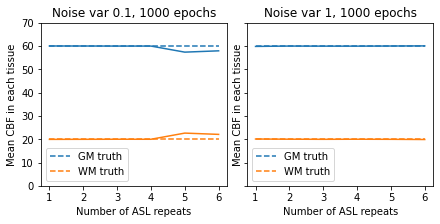

In [6]:
repeats = np.arange(1, 7)

NOISE = [0.1, 1]
fig, axes = plt.subplots(1, len(NOISE), sharey=True, constrained_layout=True, figsize=(6,3))

for noise, ax in zip(NOISE, axes): 

    cbf_mean = np.zeros((len(repeats), 2))
    for idx,rpt in enumerate(repeats): 

        opath = f"svb_problems/low_noise_var-{noise}_rpts-{rpt}"
        data = simulate_data(noise, rpt)
        runtime, svb, training_history = run(
            data, "aslrest", opath, repeats=rpt, inferatt=True, **options)

        mcbf = np.squeeze(training_history['param_means'][:,-1,[0,2]].T)
        cbf_mean[idx,:] = mcbf.mean(1)

    ax.plot(repeats, cbf_mean[:,0], color='tab:blue')
    ax.plot([repeats[0], repeats[-1]], [60, 60], color='tab:blue', linestyle='--', label='GM truth')
    ax.plot(repeats, cbf_mean[:,1], color='tab:orange')
    ax.plot([repeats[0], repeats[-1]], [20, 20], color='tab:orange', linestyle='--', label='WM truth')
    ax.set_ylim(0,70)
    ax.legend()
    ax.set_xlabel('Number of ASL repeats')
    ax.set_ylabel('Mean CBF in each tissue')
    ax.set_title(f'Noise var {noise}, {options["epochs"]} epochs')

At extremely low noise, the result with higher number of data repeats actually gets worse. The optimisation gets stuck in a minimum and never climbs out of it. 

With slightly higher noise, increasing number of repeats has the desired effect of improving the accuracy of the results. As far as I can tell, these results hold when using sample size inflation, and 

In [65]:
fov = 20 * np.ones(3, dtype=int)
vox_size = 2 * np.ones(3, dtype=int)
spc = rt.ImageSpace.create_axis_aligned(np.zeros(3), fov/vox_size, vox_size)
spc 

ImageSpace with properties:
size:          [  10.000   10.000   10.000], 
voxel size:    [   2.000    2.000    2.000], 
field of view: [  20.000   20.000   20.000],
vox2world:     [   2.000    0.000    0.000    1.000]
               [   0.000    2.000    0.000    1.000]
               [   0.000    0.000    2.000    1.000]
               [   0.000    0.000    0.000    1.000]
loaded from:   <ImageSpace not created from file path>

In [73]:
sph = trimesh.creation.icosphere(4)
shift = (spc.fov_size / 2)

outsurf = tob.Surface.manual((9.5 * sph.vertices) + shift, sph.faces, 'LPS')
insurf = tob.Surface.manual((7 * sph.vertices) + shift, sph.faces, 'LWS')
hemi = tob.Hemisphere(insurf, outsurf, 'L')
midsurf = hemi.midsurface()
outsurf

Surface with 2562 points and 5120 triangles. 
min (X,Y,Z):  [0.5 0.5 0.5]
mean (X,Y,Z): [ 9.999999 10.        9.999993]
max (X,Y,Z):  [19.5 19.5 19.5]

Initialising projector (will take some time)


L cortex in: 100%|########## 00:01 | 00:00
L cortex out: 100%|########## 00:01 | 00:00


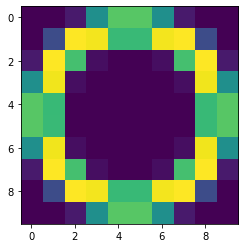

In [74]:
proj = tob.Projector(hemi, spc)
pvs = proj.pvs()
plt.imshow(proj.pvs()[...,spc.size[-1]//2,0])

In [75]:
def cart2sph(x, y, z):
    hxy = np.hypot(x, y)
    r = np.hypot(hxy, z)
    el = np.arctan2(z, hxy)
    az = np.arctan2(y, x)
    return az, el, r

az, el, r = cart2sph(*(midsurf.points - midsurf.points.mean(0)).T)

def pv_plot(surface, data, **kwargs):
    faces = 3 * np.ones((surface.tris.shape[0], 4), dtype=int)
    faces[:,1:] = surface.tris 
    mesh = pv.PolyData(surface.points, faces=faces)
    mesh.plot(pbr=True, jupyter_backend='pythreejs', scalars=data, window_size=(600, 400), **kwargs)

scale = 5
ctx_cbf = 40 + 20 * (np.sin(scale * el)**2 + np.sin(scale/2 * az)**2)
ctx_cbf_vol = proj.surf2vol(ctx_cbf, edge_scale=False)
print(ctx_cbf.min(), ctx_cbf.max())
pv_plot(midsurf, ctx_cbf, clim=[40, 80]) 

40.0 79.77042


Renderer(camera=PerspectiveCamera(aspect=1.5, children=(DirectionalLight(intensity=0.25, position=(0.0, 0.0, 1…

In [76]:
PLDS = [0.5, 0.75, 1.0, 1.25, 1.5, 1.75]
BOLUS = 1.8
ATT = [1.3, 1.6]
BASIL_OPTS = { 'tau': BOLUS, 'bat': ATT[0], 'batwm': ATT[1], 'plds': PLDS, }
mask = (proj.pvs()[...,:2] > 0.01).any(-1)
nvox = spc.size.prod()
nverts = midsurf.n_points

In [77]:
def simulate_data(noise, rpt):
    
    data = np.zeros((*spc.size, len(PLDS) * rpt))
    data_model = HybridModel(spc.make_nifti(data), projector=proj)
    asl_model = AslRestModel(data_model,
            plds=PLDS, repeats=rpt, casl=True, inferatt=False)

    with tf.Session() as sess:
        cbf = np.concatenate([
                ctx_cbf[:,None], 20 * np.ones([nvox, 1]) ])

        data = sess.run(asl_model.evaluate(
                [ cbf.astype(np.float32) ], asl_model.tpts()))

    data = proj.hybrid2vol(data, edge_scale=True).reshape(*spc.size, -1)
    data[mask,:] += np.random.normal(0, noise, size=data[mask,:].shape)
    return data


In [78]:
options = {
    "mode": "hybrid", 
    "projector": proj, 

    "learning_rate" : 0.25,
    "lr_decay_rate": 0.5, 
    "sample_size" : 4,
    "ss_increase_factor": 8, 
    "epochs" : 1000,

    "batch_size" : len(PLDS),
    "log_stream" : sys.stdout,
    "mask" : mask,
    "plds": PLDS, 
    "casl": True, 
    "prior_type": "M",
    "display_step": 50, 

    "save_model_fit": True, 
    "save_mean": True, 
    "save_input": True, 
}

['oxasl', '-i', 'hybrid_test/basil_surf/asl.nii.gz', '-m', 'hybrid_test/basil_surf/mask.nii.gz', '-o', 'hybrid_test/basil_surf', '--iaf', 'diff', '--order', 'rt', '--fit-options', 'hybrid_test/basil_surf/bopts.txt', '--casl', '--artoff', '--debug', '--no-report', '--overwrite', '--plds', '0.5,0.75,1.0,1.25,1.5,1.75', '--pvcorr', '--pvgm', 'hybrid_test/basil_surf/pvgm.nii.gz', '--pvwm', 'hybrid_test/basil_surf/pvwm.nii.gz']
OXASL version: 0.2.0.post15

Input ASL data: asldata
Data shape                    : (10, 10, 10, 18)
Label type                    : Already differenced
Labelling                     : CASL/pCASL
PLDs (s)                      : [0.5, 0.75, 1.0, 1.25, 1.5, 1.75]
Repeats at each TI            : [3, 3, 3, 3, 3, 3]
Bolus durations (s)           : [1.8, 1.8, 1.8, 1.8, 1.8, 1.8]
TEs (s)                       : [0]

Initialising structural data
 - No structural data supplied - output will be native space only

Applying data corrections
 - No corrections to apply to ASL dat

/var/folders/lv/mwp4mfb163n5t2wqyhm281vm0000gn/T/ipykernel_71728/2602471097.py:33: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


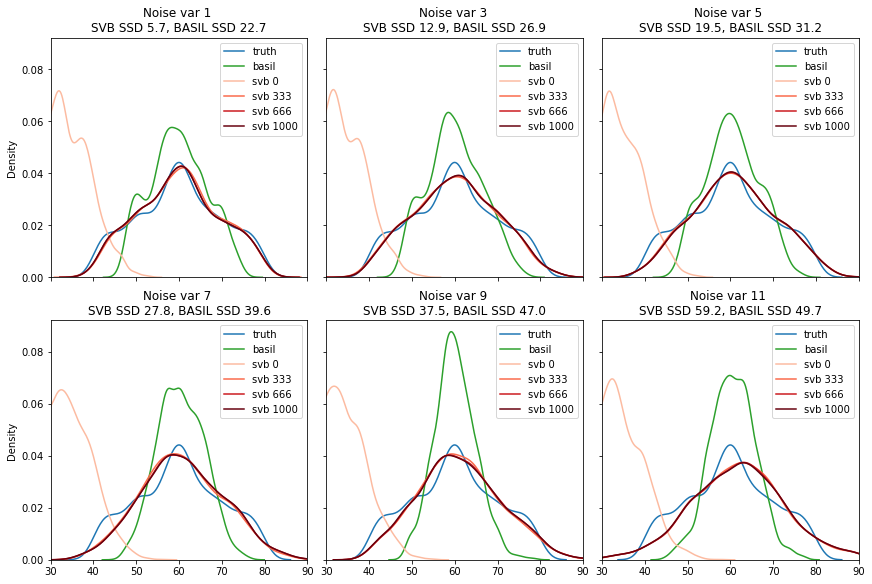

In [102]:
NOISE = [1,3,5,7,9,11]
rpt = 3
fig, axes = plt.subplots(2, 3, constrained_layout=True, figsize=(12,8), sharex=True, sharey=True)

# Run with a fixed low level of noise and varying numbers of repeats 
for idx,(noise,ax) in enumerate(zip(NOISE,axes.flat)): 

    data = simulate_data(noise, rpt)
    sns.kdeplot(x=ctx_cbf, label='truth', ax=ax, color=cmap[0])

    # BASIL infer att 
    basil_surf = fabber_funcs.oxasl_cmd(data, mask, 'hybrid_test/basil_surf', { **BASIL_OPTS, 'repeats': rpt }, pvs[...,:2], proj, inferatt=True)
    sns.kdeplot(x=basil_surf, label='basil', ax=ax, color=cmap[2])
    basil_ssd = ((ctx_cbf - basil_surf) ** 2).mean()

    # SVB infer att 
    runtime, svb, training_history = run(
        spc.make_nifti(data), "aslrest",
        "hybrid_test", repeats=rpt, inferatt=True,
        **options)
    svb_surf = training_history['param_means'][:nverts,-1,0].T
    svb_ssd = ((ctx_cbf - svb_surf) ** 2).mean()

    reds = get_cmap('Reds')
    increments = np.linspace(0, options["epochs"], 4).astype(int)
    for eidx, ep in enumerate(increments): 
        sns.kdeplot(x=training_history['param_means'][:nverts,ep,0].T, ax=ax, color=reds((eidx+1) / increments.size), label=f'svb {ep}')

    ax.set_title(f'Noise var {noise} \nSVB SSD {svb_ssd:.1f}, BASIL SSD {basil_ssd:.1f}')
    ax.legend()
    ax.set_xlim(30, 90)

fig.show()

In [103]:
pv_plot(midsurf, svb_surf, clim=[40,80])

Renderer(camera=PerspectiveCamera(aspect=1.5, children=(DirectionalLight(intensity=0.25, position=(0.0, 0.0, 1…

In [104]:
pv_plot(midsurf, basil_surf, clim=[40,80])

Renderer(camera=PerspectiveCamera(aspect=1.5, children=(DirectionalLight(intensity=0.25, position=(0.0, 0.0, 1…